# Embeddings

Embeddings are a way of encoding texts into vectors. The idea is that a chunks of text that are semantically similar are also close in the vector space. This is useful for many tasks in NLP, such as text classification, question answering and machine translation.

Later we will create a chat bot that uses embeddings to find the most relevant data to user queries and use that to answer questions. But first, let's have a look at how embeddings work.

We will compare open source library `SentenceTransformers` to `OpenAI`. In order to plot the embeddings in 3D, we will use a dimensionality reduction technique called `PCA` since those embeddings are of size 768 and 1536 respectively.

The example shown here is based on the assumpion that the word 'queen' can be semantically obtained from the word 'king' by the equation

'queen' = 'king' - 'man' + 'woman'

We will check how close those points ends up reduced to 3D.

In [1]:
import numpy as np
import dotenv

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer 
from langchain.embeddings import OpenAIEmbeddings

dotenv.load_dotenv()

# there are a few models in sentence transformers family, this one is the best according to the benchmarks
open_source_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  
open_ai_model = OpenAIEmbeddings()

words = ['king', 'queen', 'man', 'woman']
 
embedding_open_source = np.array(open_source_model.encode(words))
embedding_open_ai = np.array(open_ai_model.embed_documents(words))

/Users/barteksadlej/Desktop/PROJECTS/workshops/LLM_intro/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Normalization

It is generaly usefull to normalize the embeddings vectors to have |v| = 1.
There are many reasons for this, but probably the most important ones are:

<strong>Iproved Generalization</strong>:
    Normalized embeddings often lead to models that generalize better to unseen data. When features have similar scales, the model is less likely to overweight certain dimensions, leading to a more balanced representation.

<strong>Ehanced Interpretability</strong>:
   Normalized embeddings can be easier to interpret. Without normalization, the magnitude of the features might overshadow their actual importance. After normalization, we can simply interpret the angle between the vectors as a measure of similarity.

`OpenAI` Embeddings are normalized by default, but `SentenceTransformers` are not. So we will normalize them before plotting.

In [2]:
embedding_open_source = embedding_open_source / np.linalg.norm(embedding_open_source, axis=1, keepdims=True)

In [3]:
def reduce_dimension(vectors: np.array) -> np.array:
    pca = PCA(n_components=3, svd_solver='full')
    pca.fit(vectors)
    return pca.transform(vectors)

def plot_embeddings(embeddings: np.array, words: list, title: str):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    for (word, emb) in zip(words, embeddings):
        ax.scatter(emb[0], emb[1], emb[2])
        ax.text(emb[0], emb[1], emb[2], word)

    ax.set_title(title)

    plt.show()

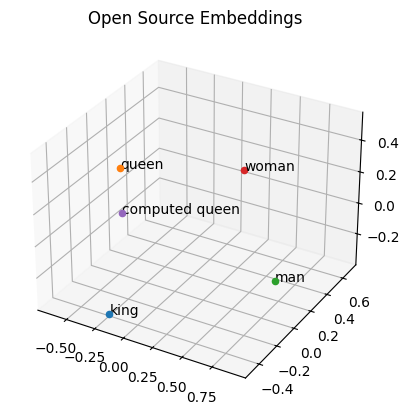

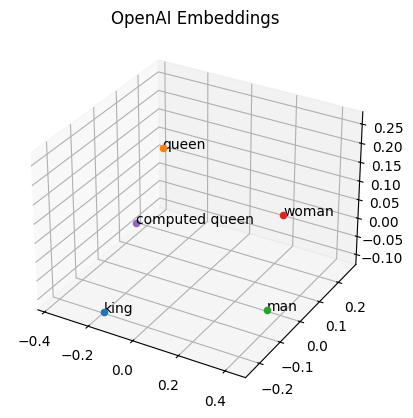

In [4]:
open_source_queen = embedding_open_source[0] - embedding_open_source[2] + embedding_open_source[3]
open_ai_queen = embedding_open_ai[0] - embedding_open_ai[2] + embedding_open_ai[3]

# new vectors are not normalized
open_source_queen = open_source_queen / np.linalg.norm(open_source_queen)
open_ai_queen = open_ai_queen / np.linalg.norm(open_ai_queen)

words2 = words + ['computed queen']
embedding_open_source2 = np.concatenate([embedding_open_source, open_source_queen.reshape(1, -1)])
embedding_open_ai2 = np.concatenate([embedding_open_ai, open_ai_queen.reshape(1, -1)])

plot_embeddings(reduce_dimension(embedding_open_source2), words2, 'Open Source Embeddings')
plot_embeddings(reduce_dimension(embedding_open_ai2), words2, 'OpenAI Embeddings')

The opensource models seems to be working slightly better. It is important to note, that we are reducing the dimensionality to only 3D from a very high number so we are loosing a lot of information. The embeddings are actually 768 and 1536 dimensional vectors.

But in general, opensource embeddings are consider very good, the only drawback is that they have much shorter context length.

We will use `OpenAI` embeddings during workshop since they are very easy and cheap to work with.

In [5]:
open_source_model.max_seq_length, open_ai_model.embedding_ctx_length

(384, 8191)